In [1]:
!pip install Sastrawi

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
df = pd.read_csv('dataset_sms_spam_v1.csv')
df

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0
1140,Mba mau kirim 300 ya,0
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0


# Data Preprocessing

In [3]:
df['label'].value_counts()

# 0: sms normal
# 1: fraud atau penipuan
# 2: promo

,count
label,
0,569
1,335
2,239


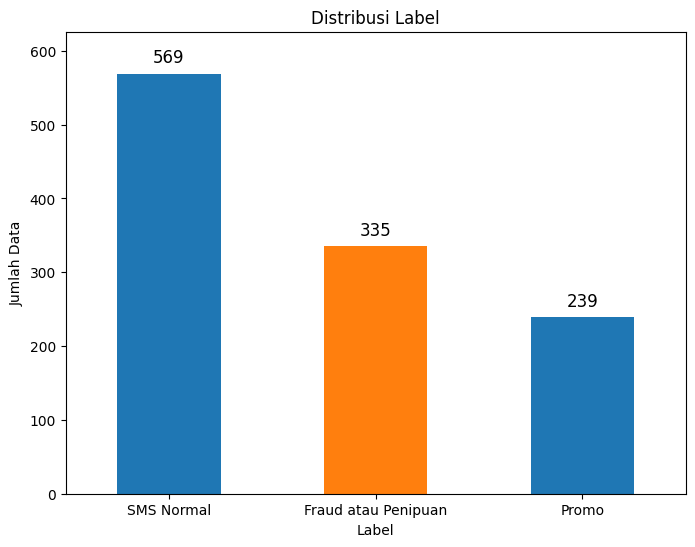

In [15]:
# Data
label_counts = df['label'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.xticks([0, 1, 2], ['SMS Normal', 'Fraud atau Penipuan', 'Promo'], rotation=0)
plt.ylim(0, label_counts.max() * 1.1)
for i, v in enumerate(label_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=12)
plt.show()

In [5]:
def clean_text(text):
    # Menghapus tanda baca dan simbol
    text = re.sub(r'[^\w\s]', ' ', text)
    # Menghapus angka
    text = re.sub(r'\d+', '', text)
    # Menghilangkan spasi berlebih
    text = re.sub(r'\s+', ' ', text)
    # Mengubah ke huruf kecil
    return text.lower()

df['Teks_clean'] = df['Teks'].apply(clean_text)
df.head()

,Teks,label,Teks_clean
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash mulai gb di my telkoms...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,gb hari hanya rp ribu spesial buat anda yang ...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,plg yth sisa kuota flash anda kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,plg yth sisa kuota flash anda kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,gb hari hanya rp ribu spesial buat anda yang ...


In [6]:
# Mendapatkan stopwords untuk Bahasa Indonesia
stopwords_list = stopwords.words('indonesian')

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords_list]
    return ' '.join(filtered_words)

df['Teks_stopwords'] = df['Teks_clean'].apply(remove_stopwords)

In [7]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df['Teks_stemming'] = df['Teks_stopwords'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [8]:
df

,Teks,label,Teks_clean,Teks_stopwords,Teks_stemming
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash mulai gb di my telkoms...,promo beli paket flash gb my telkomsel app dpt...,promo beli paket flash gb my telkomsel app dpt...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,gb hari hanya rp ribu spesial buat anda yang ...,gb rp ribu spesial terpilih aktifkan promo sd ...,gb rp ribu spesial pilih aktif promo sd nov bu...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,plg yth sisa kuota flash anda kb download myt...,plg yth sisa kuota flash kb download mytelkoms...,plg yth sisa kuota flash kb download mytelkoms...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,plg yth sisa kuota flash anda kb download myt...,plg yth sisa kuota flash kb download mytelkoms...,plg yth sisa kuota flash kb download mytelkoms...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,gb hari hanya rp ribu spesial buat anda yang ...,gb rp ribu spesial terpilih aktifkan buruan skb,gb rp ribu spesial pilih aktif buru skb
...,...,...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo sama oke nanti aku umumin di grup kelas,yooo oke umumin grup kelas,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,sebelumnya ga ad nulis kerudung kirain warna ...,ga ad nulis kerudung kirain warna jins,ga ad nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mba mau kirim ya,mba kirim ya,mba kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagi mau cas atay tranfer,nama beaok bwrangkat pagi cas atay tranfer,nama beaok bwrangkat pagi cas atay tranfer


In [9]:
# Menyimpan DataFrame ke file CSV
df.to_csv('sms_cleaning.csv', index=False)

In [10]:
df[df['label'] == 1]

,Teks,label,Teks_clean,Teks_stopwords,Teks_stemming
239,"Jika anda bermasalah dgn CC/KT@, stres dgn bun...",1,jika anda bermasalah dgn cc kt stres dgn bunga...,bermasalah dgn cc kt stres dgn bunga pelunasan...,masalah dgn cc kt stres dgn bunga lunas disc s...
240,"Lelah byr min payment? Kami Solusinya, bantu s...",1,lelah byr min payment kami solusinya bantu sec...,lelah byr min payment solusinya bantu legal pe...,lelah byr min payment solusi bantu legal tutup...
241,"Dana Tunai (KTA) bunga 0,99% hingga 300 jt. Sy...",1,dana tunai kta bunga hingga jt syarat ktp cc b...,dana tunai kta bunga jt syarat ktp cc dgn bpkb...,dana tunai kta bunga jt syarat ktp cc dgn bpkb...
242,“ROXI CELL” Hanya dengan Rp.100rb Anda bisa ja...,1,roxi cell hanya dengan rp rb anda bisa jadi a...,roxi cell rp rb agen pulsa elektrik operator g...,roxi cell rp rb agen pulsa elektrik operator g...
243,3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN...,1,ramadhan selamat anda pemenang rp jt pin code...,ramadhan selamat pemenang rp jt pin code yrkz ...,ramadhan selamat menang rp jt pin code yrkz in...
...,...,...,...,...,...
569,Yth Bpk/Ibu. BNI menyatakan Rekening anda terp...,1,yth bpk ibu bni menyatakan rekening anda terpi...,yth bpk bni rekening terpilih pemenang hadiah ...,yth bpk bni rekening pilih menang hadiah rp jt...
570,Yth Isti Sofiyah. Diminta Segera Hubungi Bpk D...,1,yth isti sofiyah diminta segera hubungi bpk dr...,yth isti sofiyah hubungi bpk drs h safi i m pd...,yth isti sofiyah hubung bpk drs h safi i m pd ...
571,YTH kpd bpk/ibu sy Eka Novitasari kariyawan 3c...,1,yth kpd bpk ibu sy eka novitasari kariyawan ca...,yth kpd bpk sy eka novitasari kariyawan care m...,yth kpd bpk sy eka novitasari kariyawan care m...
572,"YTH,MIitra Silahkan cek poin anda dan tukarkan...",1,yth miitra silahkan cek poin anda dan tukarkan...,yth miitra silahkan cek poin tukarkan admin fo...,yth miitra silah cek poin tukar admin format p...


In [11]:
# Split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(df['Teks_stemming'], df['label'], test_size=0.3, random_state=42) # Training 70% Testing 30%

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Konversi representasi BoW ke DataFrame
bow_df_train = pd.DataFrame(X_train_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df_test = pd.DataFrame(X_test_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

In [12]:
bow_df_train.head()

,aa,aad,aamiiiin,aamiin,ab,abadi,abbee,abdul,abdullah,abis,...,yrkz,ytg,yth,yu,yuk,yuks,yuni,yunit,zarkasi,zona
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
bow_df_test.head()

,aa,aad,aamiiiin,aamiin,ab,abadi,abbee,abdul,abdullah,abis,...,yrkz,ytg,yth,yu,yuk,yuks,yuni,yunit,zarkasi,zona
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

# Konversi representasi TF-IDF ke DataFrame
tfidf_df_train = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df_test = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [17]:
tfidf_df_train.head()

,aa,aad,aamiiiin,aamiin,ab,abadi,abbee,abdul,abdullah,abis,...,yrkz,ytg,yth,yu,yuk,yuks,yuni,yunit,zarkasi,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
tfidf_df_test.head()

,aa,aad,aamiiiin,aamiin,ab,abadi,abbee,abdul,abdullah,abis,...,yrkz,ytg,yth,yu,yuk,yuks,yuni,yunit,zarkasi,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.236518,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [19]:
X_train = tfidf_df_train
X_test = tfidf_df_test

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 2741), (800,), (343, 2741), (343,))

# Training-Testing-Evaluasi Model

In [45]:
label_names = ['SMS Normal', 'Fraud atau Penipuan', 'Promo']

param_dist = {
    'alpha': np.logspace(-3, 2, 100)  # Random search pada skala log untuk nilai alpha
}

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=1, random_state=42)

# Melatih model dengan RandomizedSearch
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=MultinomialNB(), n_iter=100,
                   param_distributions={'alpha': array([1.00000000e-03, 1.12332403e-03, 1.26185688e-03, 1.41747416e-03,
       1.59228279e-03, 1.78864953e-03, 2.00923300e-03, 2.25701972e-03,
       2.53536449e-03, 2.84803587e-03, 3.19926714e-03, 3.59381366e-03,
       4.03701726e-03, 4.53487851e-03, 5.09413801e-03, 5.72236766e-03,
       6.42807312e-0...
       6.89261210e+00, 7.74263683e+00, 8.69749003e+00, 9.77009957e+00,
       1.09749877e+01, 1.23284674e+01, 1.38488637e+01, 1.55567614e+01,
       1.74752840e+01, 1.96304065e+01, 2.20513074e+01, 2.47707636e+01,
       2.78255940e+01, 3.12571585e+01, 3.51119173e+01, 3.94420606e+01,
       4.43062146e+01, 4.97702356e+01, 5.59081018e+01, 6.28029144e+01,
       7.05480231e+01, 7.92482898e+01, 8.90215085e+01, 1.00000000e+02])},
                   random_state=42, scoring='accuracy', verbose=1)

In [46]:
# Dapatkan model terbaik
best_model = random_search.best_estimator_

# Prediksi pada set testing
y_pred = best_model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Naive Bayes Model Accuracy: {accuracy}")

Best Naive Bayes Model Accuracy: 0.9446064139941691


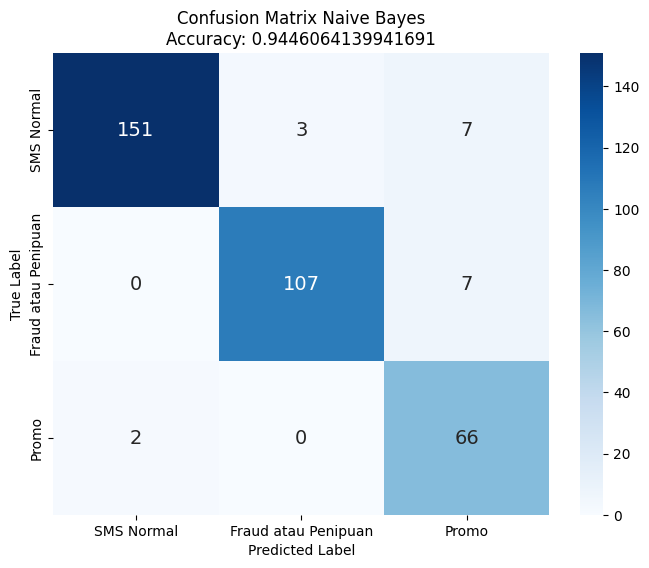

In [47]:
# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names, annot_kws={"size": 14})
plt.title(f'Confusion Matrix Naive Bayes\nAccuracy: {accuracy}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [50]:
# Simpan model terbaik
with open('naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Predict

In [51]:
def predict_sms(model_filename, sms_text, vectorizer_filename):
    # Load the model and vectorizer
    try:
        with open(model_filename, 'rb') as model_file:
            model = pickle.load(model_file)
        with open(vectorizer_filename, 'rb') as vectorizer_file:
            tfidf_vectorizer = pickle.load(vectorizer_file)
    except Exception as e:
        raise RuntimeError(f"Error loading model or vectorizer: {e}")

    # Preprocess the text
    cleaned_text = clean_text(sms_text)

    # Convert text to features
    features = tfidf_vectorizer.transform([cleaned_text])

    # Predict using the model
    prediction = model.predict(features)

    # Handle the prediction result
    if prediction[0] == 0:
        return "SMS Normal"
    elif prediction[0] == 1:
        return "Fraud atau Penipuan"
    else:
        return "Promo"

# Example usage:
sms_text = "dijamin menang"
predicted_label = predict_sms("naive_bayes_model.pkl", sms_text, "tfidf_vectorizer.pkl")
print("Predicted label:", predicted_label)


Predicted label: Fraud atau Penipuan
